In [25]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("result_sysbench.csv")
databases = data.index

## Transactions Per Second

In [ ]:
transactions_per_second = data['Transactions per second']

plt.figure(figsize=(7, 4))
plt.bar(databases, transactions_per_second)
plt.xlabel('Database')
plt.ylabel('Transactions per second')
plt.title('Transactions per second for different Databases')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## Number of Queries

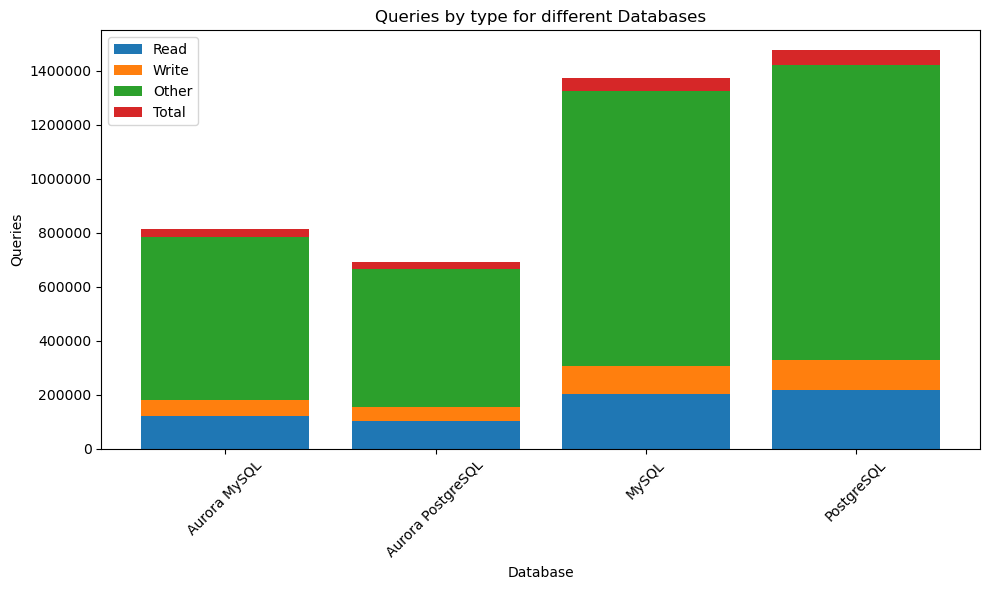

In [28]:
reads = data['Read']
writes = data['Write']
others = data['Other']
totals = data['Total']

# Create stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(databases, reads, label='Read')
plt.bar(databases, writes, bottom=reads, label='Write')
plt.bar(databases, others, bottom=reads+writes, label='Other')
plt.bar(databases, totals, bottom=reads+writes+others, label='Total')

plt.xlabel('Database')
plt.ylabel('Queries')
plt.title('Queries by type for different Databases')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.tight_layout()
plt.show()